<a href="https://colab.research.google.com/github/kunan-au/Modeling_Risk/blob/main/Feature_Engineering_Doing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Seeking Factors

Minimize

Model using


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Package

In [ ]:
!pip install requests pandas matplotlib scipy statsmodels
!pip install yfinance

In [ ]:
import requests
import pandas as pd
import gspread
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
from google.auth import default
import statsmodels.api as sm
from scipy import stats
import yfinance as yf
import getpass

Data Importing

In [ ]:
#Setup for Google Sheets API
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
def get_sheet_data(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df['Date'] = pd.to_datetime(df['Date'].str.split().str[0], format='%m/%d/%Y').dt.date
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [ ]:
sheet_names = ["MSFT", "META", "NFLX"]

dataframes = [get_sheet_data(name) for name in sheet_names]

combined_df = pd.concat(dataframes, ignore_index=True)

for df in dataframes:
    print(df.head())

0        Date    Open    High     Low   Close    Volume
1  2022-01-03  335.35  338.00  329.78  334.75  28918013
2  2022-01-04  334.83  335.20  326.12  329.01  32674306
3  2022-01-05  325.86  326.07  315.98  316.38  40054327
4  2022-01-06  313.15  318.70  311.49  313.88  39646148
5  2022-01-07  314.15  316.50  310.09  314.04  32720018
0        Date    Open    High     Low   Close    Volume
1  2022-01-03  338.30  341.08  337.19  338.54  14562849
2  2022-01-04  339.95  343.09  331.87  336.53  15997974
3  2022-01-05  333.02  335.76  323.84  324.17  20564521
4  2022-01-06  322.82  339.17  322.72  332.46  27962809
5  2022-01-07  332.74  337.00  328.88  331.79  14722020
0        Date    Open    High     Low   Close   Volume
1  2022-01-03  605.61  609.99  590.56  597.37  3068808
2  2022-01-04  599.91  600.41  581.60  591.15  4393135
3  2022-01-05  592.00  592.84  566.88  567.52  4148749
4  2022-01-06  554.34  563.36  542.01  553.29  5711795
5  2022-01-07  549.46  553.43  538.22  541.06  338287

Basic

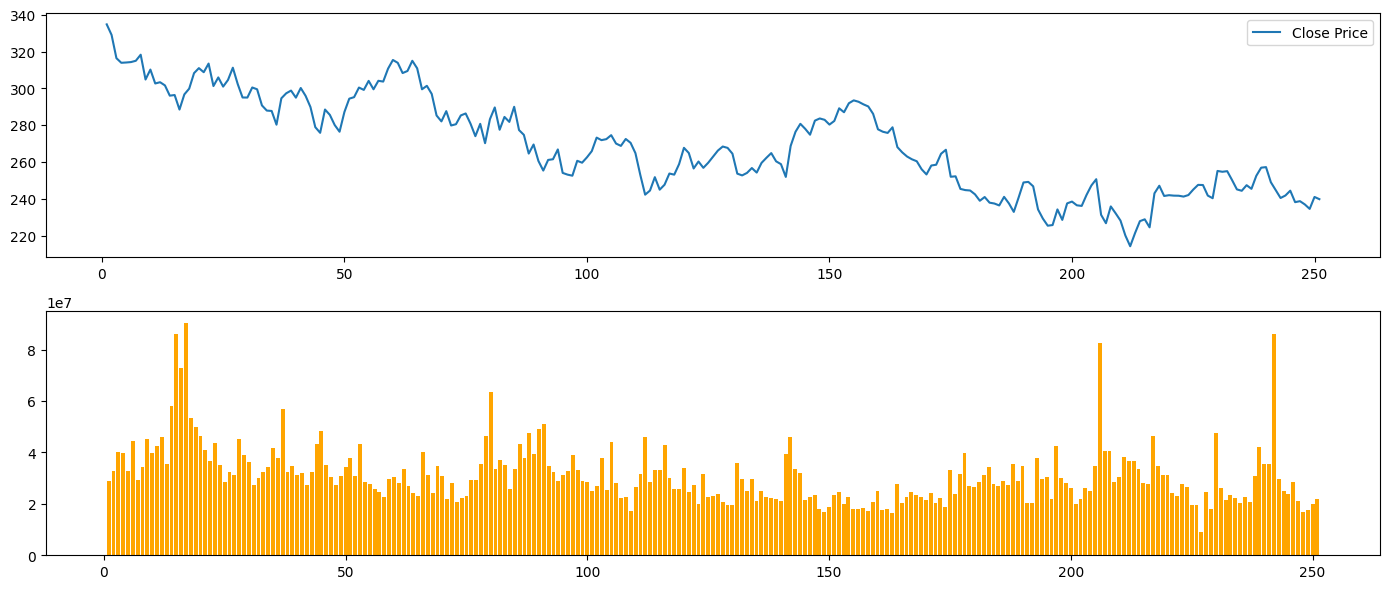

Daily Closing Prices for MSFT
Daily Volume for MSFT


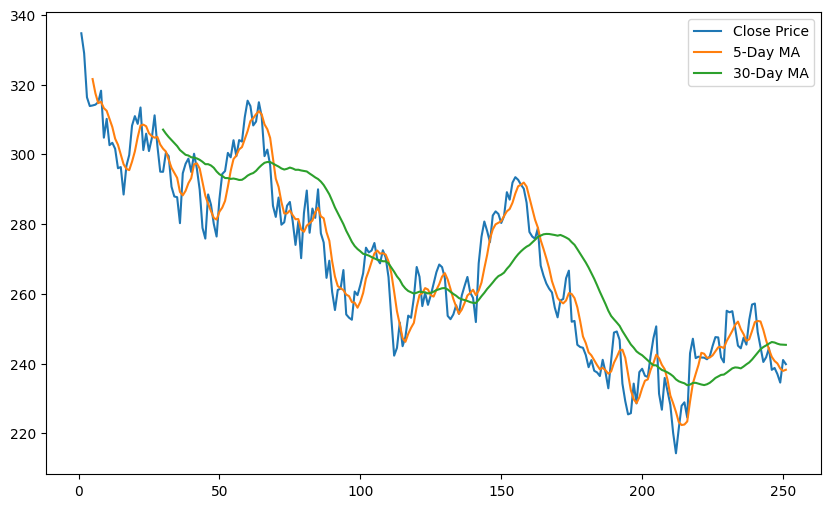

Moving Averages for MSFT


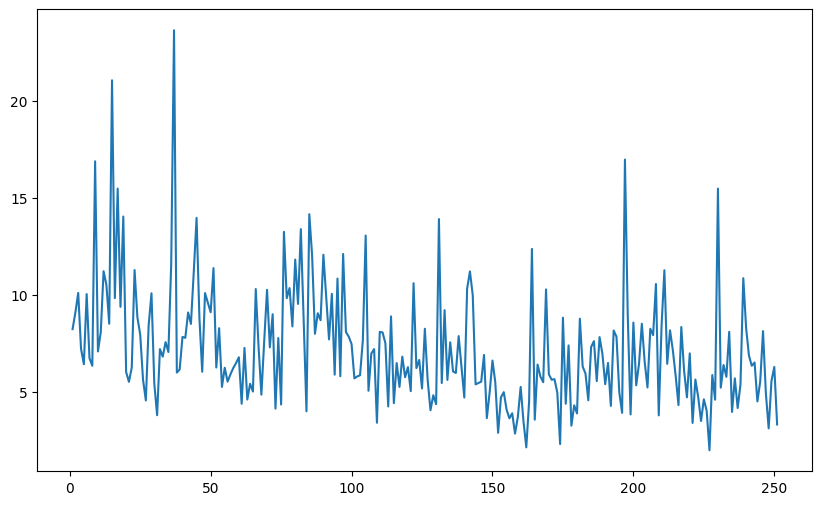

Price Fluctuation for MSFT


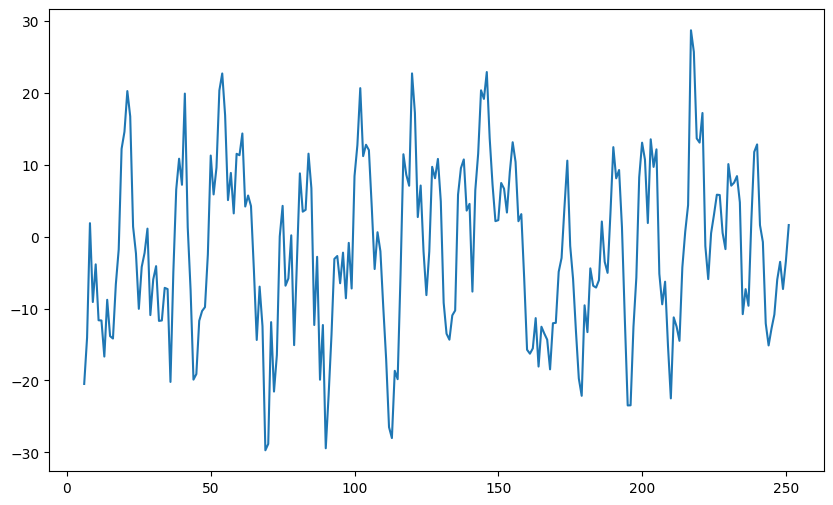

Momentum for MSFT


<ipython-input-8-26315a730645>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


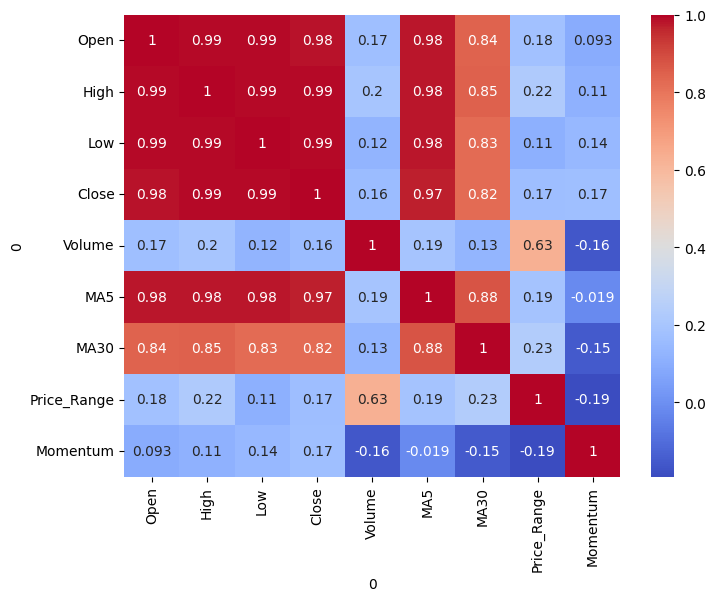

Correlation Heatmap for MSFT


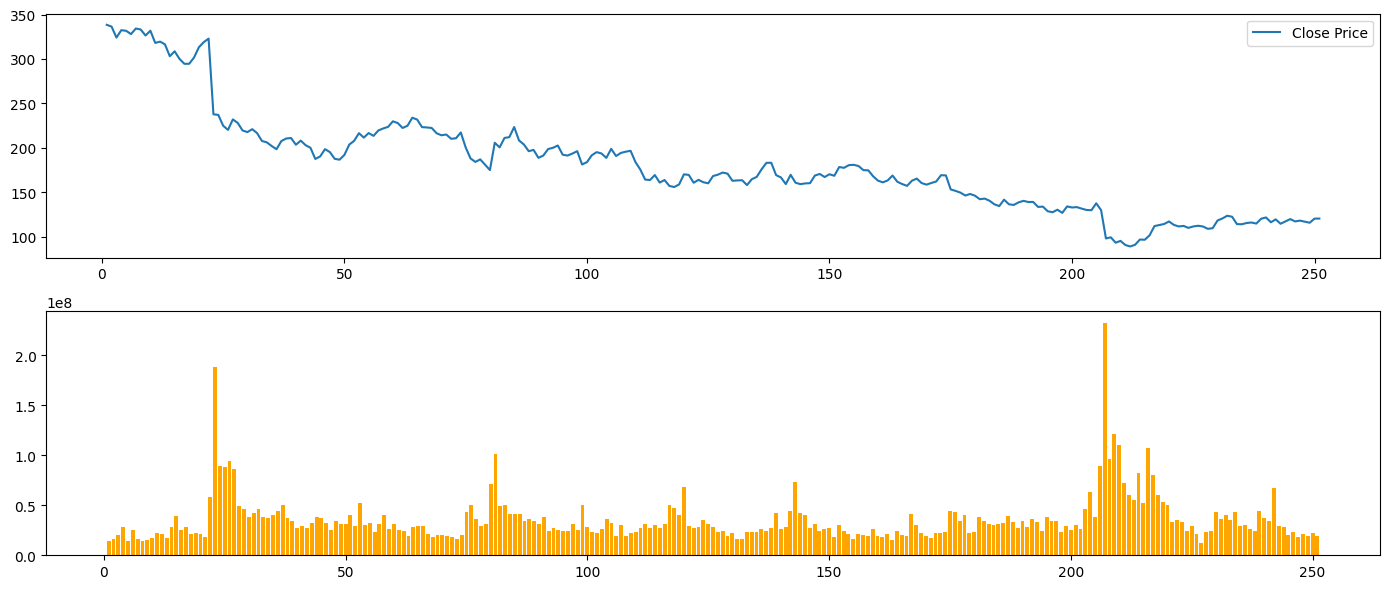

Daily Closing Prices for META
Daily Volume for META


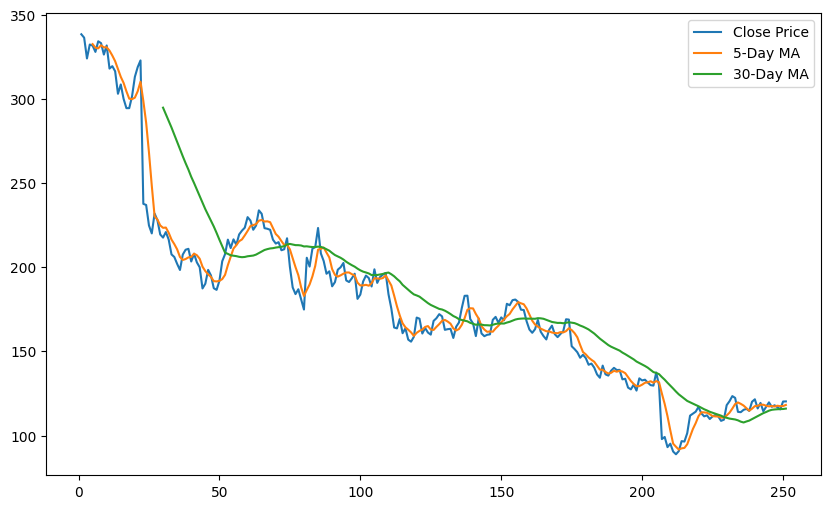

Moving Averages for META


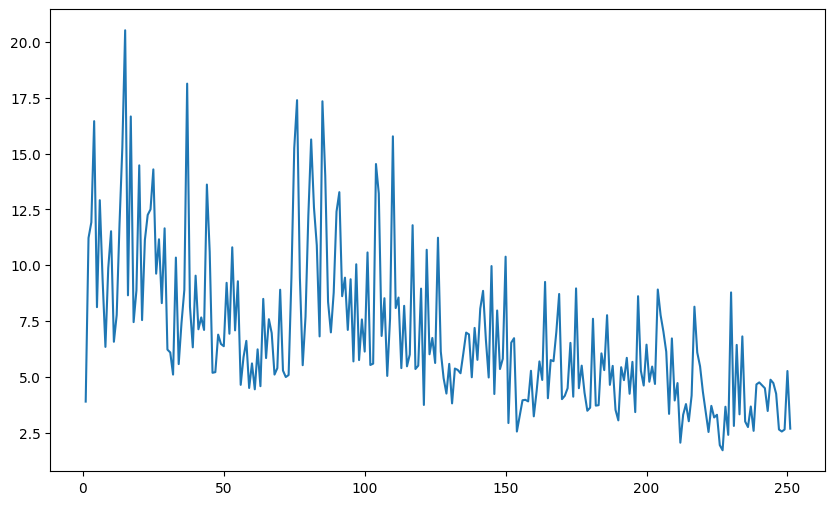

Price Fluctuation for META


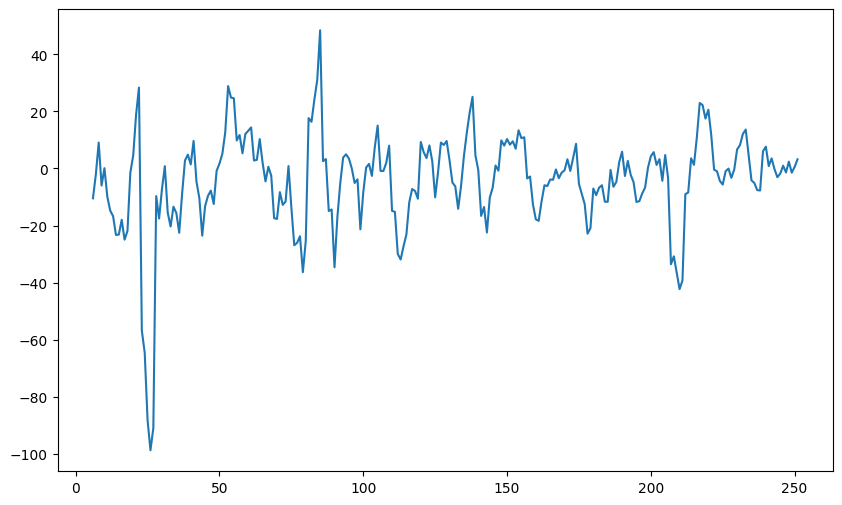

Momentum for META


<ipython-input-8-26315a730645>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


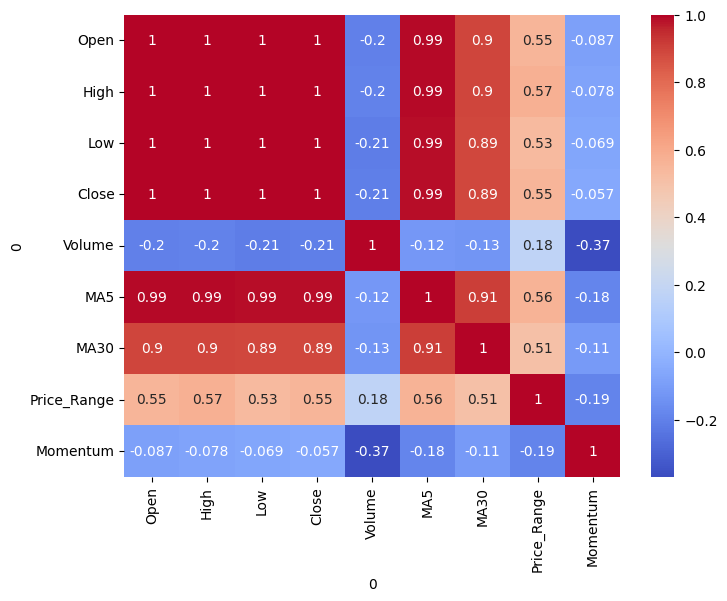

Correlation Heatmap for META


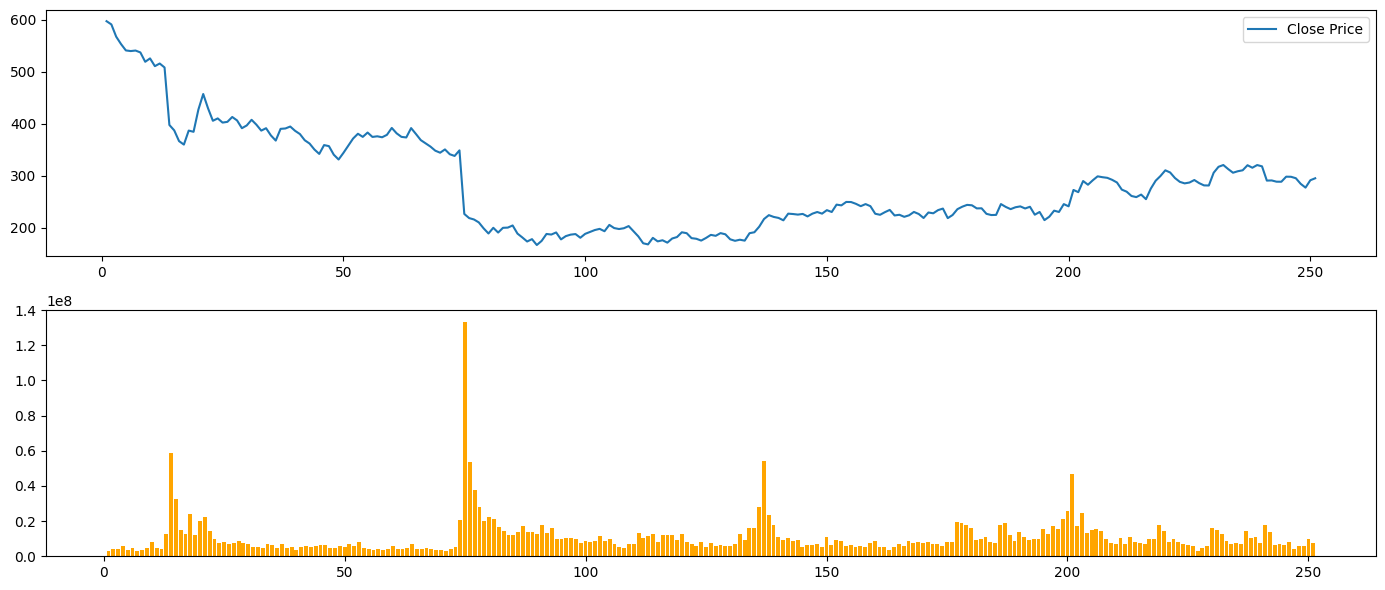

Daily Closing Prices for NFLX
Daily Volume for NFLX


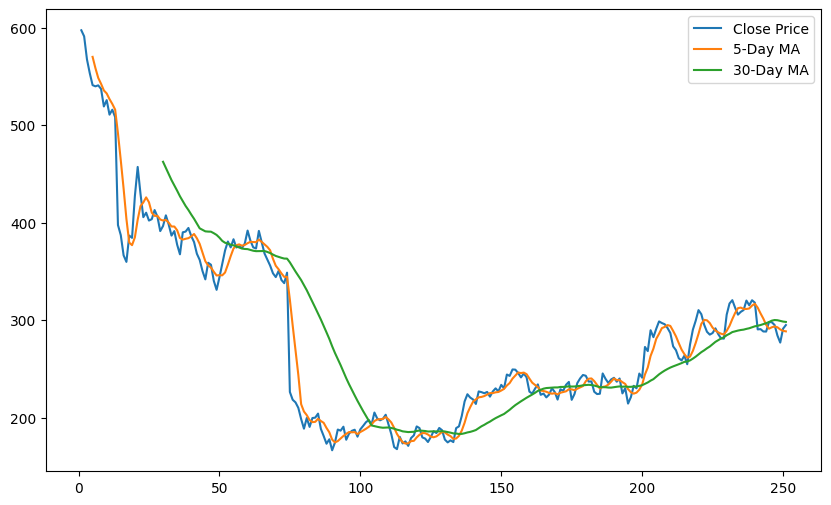

Moving Averages for NFLX


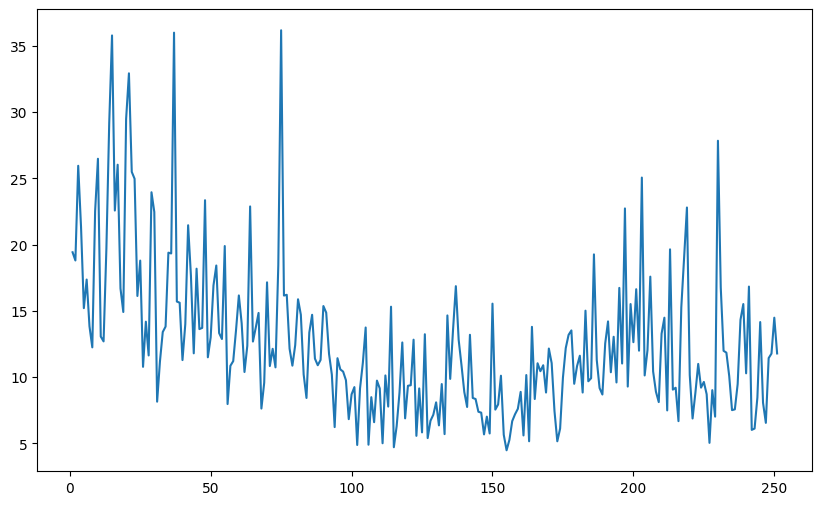

Price Fluctuation for NFLX


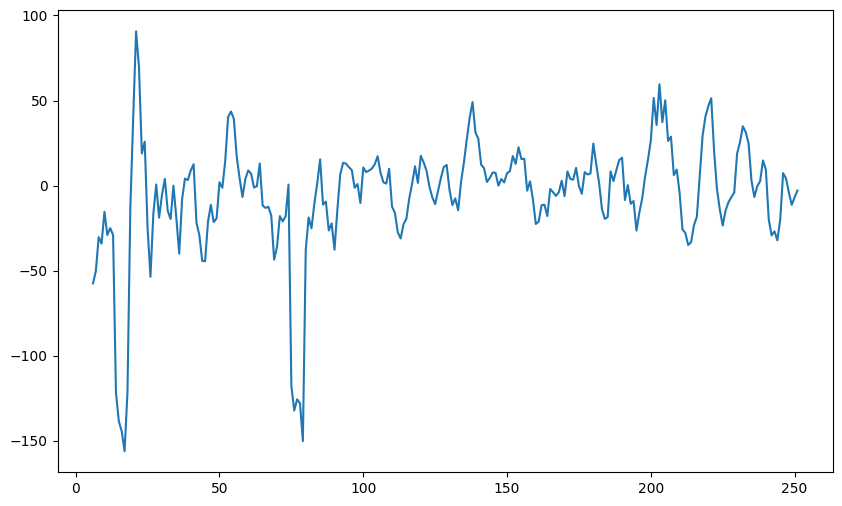

Momentum for NFLX


<ipython-input-8-26315a730645>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


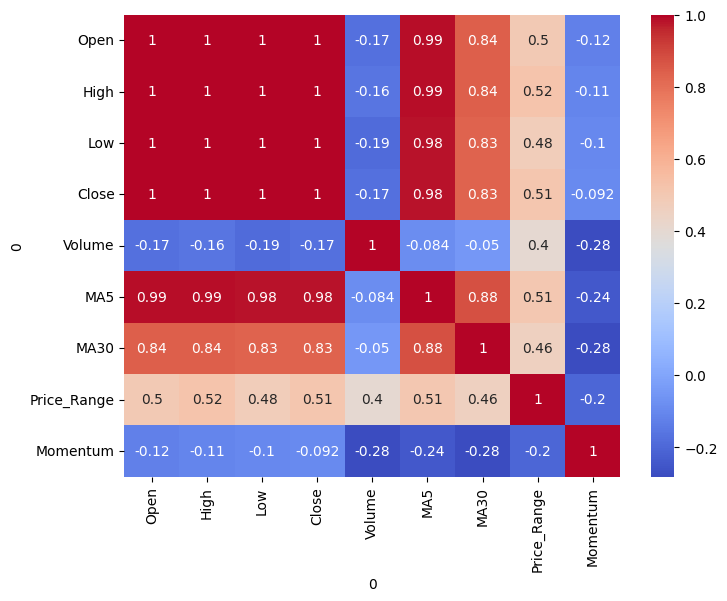

Correlation Heatmap for NFLX


In [ ]:
# Price and Volume Plot for all DataFrames
for df, name in zip(dataframes, sheet_names):
    # Price and Volume Plot
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar(df.index, df['Volume'], color='orange')
    plt.tight_layout()
    plt.show()
    print(f'Daily Closing Prices for {name}')
    print(f'Daily Volume for {name}')

    # Moving Average Plot
    plt.figure(figsize=(10, 6))
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA30'] = df['Close'].rolling(window=30).mean()
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['MA5'], label='5-Day MA')
    plt.plot(df['MA30'], label='30-Day MA')
    plt.legend()
    plt.show()
    print(f'Moving Averages for {name}')

    # Price Fluctuation Plot
    plt.figure(figsize=(10, 6))
    df['Price_Range'] = df['High'] - df['Low']
    plt.plot(df['Price_Range'])
    plt.show()
    print(f'Price Fluctuation for {name}')

    # Momentum Plot
    plt.figure(figsize=(10, 6))
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    plt.plot(df['Momentum'])
    plt.show()
    print(f'Momentum for {name}')

    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.show()
    print(f'Correlation Heatmap for {name}')

In [ ]:
# Calculate daily returns for each asset
returns_dict = {}

for asset_name, df in zip(sheet_names, dataframes):
    df['Returns'] = df['Close'].pct_change()
    returns_dict[asset_name] = df[['Date', 'Returns']].copy()

# Print the returns for each asset
for asset_name, returns_df in returns_dict.items():
    print(f"Asset: {asset_name}")
    print(returns_df.head())
    print("\n")


Asset: MSFT
0        Date   Returns
1  2022-01-03       NaN
2  2022-01-04 -0.017147
3  2022-01-05 -0.038388
4  2022-01-06 -0.007902
5  2022-01-07  0.000510


Asset: META
0        Date   Returns
1  2022-01-03       NaN
2  2022-01-04 -0.005937
3  2022-01-05 -0.036728
4  2022-01-06  0.025573
5  2022-01-07 -0.002015


Asset: NFLX
0        Date   Returns
1  2022-01-03       NaN
2  2022-01-04 -0.010412
3  2022-01-05 -0.039973
4  2022-01-06 -0.025074
5  2022-01-07 -0.022104




In [ ]:
def get_alpha_vantage_data(symbol, api_key, function="TIME_SERIES_DAILY"):
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": function,
        "symbol": symbol,
        "apikey": api_key,
        "datatype": "json"
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

In [ ]:
def process_alpha_vantage_data(data):
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df.apply(pd.to_numeric)
    df.index = pd.to_datetime(df.index)
    return df

In [ ]:
api_key = getpass.getpass("Please enter Alpha Vantage API key:")
symbol = "MSFT"

raw_data = get_alpha_vantage_data(symbol, api_key)
print(raw_data)
df = process_alpha_vantage_data(raw_data)

Please enter Alpha Vantage API key:··········
{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'MSFT', '3. Last Refreshed': '2024-01-16', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2024-01-16': {'1. open': '393.6600', '2. high': '394.0300', '3. low': '387.6229', '4. close': '390.2700', '5. volume': '27202268'}, '2024-01-12': {'1. open': '385.4900', '2. high': '388.6800', '3. low': '384.6500', '4. close': '388.4700', '5. volume': '21661153'}, '2024-01-11': {'1. open': '386.0000', '2. high': '390.6800', '3. low': '380.3800', '4. close': '384.6300', '5. volume': '27850846'}, '2024-01-10': {'1. open': '376.3700', '2. high': '384.1700', '3. low': '376.3200', '4. close': '382.7700', '5. volume': '25514245'}, '2024-01-09': {'1. open': '372.0100', '2. high': '375.9900', '3. low': '371.1900', '4. close': '375.7900', '5. volume': '20829953'}, '2024-01-08': {'1. open': '369.3000', '2. high': '375.2000', '3

In [ ]:
def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    return sp500

sp500_df = get_sp500_data('2022-01-01', '2022-12-30')

print(sp500_df.head())

market_returns = sp500_df['Close'].pct_change()

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-01-03  4778.140137  4796.640137  4758.169922  4796.560059  4796.560059   
2022-01-04  4804.509766  4818.620117  4774.270020  4793.540039  4793.540039   
2022-01-05  4787.990234  4797.700195  4699.439941  4700.580078  4700.580078   
2022-01-06  4693.390137  4725.009766  4671.259766  4696.049805  4696.049805   
2022-01-07  4697.660156  4707.950195  4662.740234  4677.029785  4677.029785   

                Volume  
Date                    
2022-01-03  3831020000  
2022-01-04  4683170000  
2022-01-05  4887960000  
2022-01-06  4295280000  
2022-01-07  4181510000  


ADV

In [ ]:
def get_risk_factors(start_date, end_date):
    try:
        ff_factors = yf.download("F-F_Research_Data_Factors_daily", start=start_date, end=end_date)

        if len(ff_factors.columns) == 4:
            ff_factors.columns = ['Market Risk Premium', 'SMB', 'HML', 'Risk Free Rate']
        elif len(ff_factors.columns) == 6:
            ff_factors.columns = ['Market Risk Premium', 'SMB', 'HML', 'Risk Free Rate', 'Column5', 'Column6']

        ff_factors = ff_factors / 100

        return ff_factors
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
start_date = '2022-01-01'
end_date = '2022-12-31'
risk_factors = get_risk_factors(start_date, end_date)

if risk_factors is not None:
    print(risk_factors.head())
else:
    print("Failed to download risk factors.")

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['F-F_RESEARCH_DATA_FACTORS_DAILY']: Exception('%ticker%: No timezone found, symbol may be delisted')


Empty DataFrame
Columns: [Market Risk Premium, SMB, HML, Risk Free Rate, Column5, Column6]
Index: []


In [ ]:
def calculate_asset_returns(df):
    asset_returns = df['Close'].pct_change().dropna()

    return asset_returns

In [ ]:
def calculate_and_visualize_volatility(df, window=20):
    returns = df['Close'].pct_change().dropna()
    volatility = returns.rolling(window=window).std()
    plt.figure(figsize=(10, 6))
    plt.plot(volatility, label='Volatility')
    plt.title('Volatility Factor')
    plt.legend()
    plt.show()

In [ ]:
def calculate_alpha_and_beta(asset_returns, market_returns):
    slope, intercept, r_value, p_value, std_err = stats.linregress(asset_returns, market_returns)
    alpha = intercept
    beta = slope
    return alpha, beta

In [ ]:
def calculate_and_visualize_sharpe_ratio(df, risk_free_rate=0.02):
    returns = df['Close'].pct_change().dropna()
    mean_return = returns.mean()
    volatility = returns.std()
    sharpe_ratio = (mean_return - risk_free_rate) / volatility

    plt.figure(figsize=(10, 6))
    plt.plot(returns, label='Asset Returns')
    plt.title('Asset Returns')
    plt.legend()
    plt.show()

    print(f'Sharpe Ratio: {sharpe_ratio}')

In [ ]:
def calculate_and_visualize_r_squared(asset_returns, market_returns):
    r_squared = np.corrcoef(asset_returns, market_returns)[0, 1] ** 2
    print(f'R-Squared Value: {r_squared}')

In [ ]:
def calculate_and_visualize_cointegration(asset1_prices, asset2_prices):
    result = statsmodels.api.OLS(asset1_prices, asset2_prices).fit()
    cointegration_pvalue = statsmodels.api.tsa.stattools.adfuller(result.resid)[1]

    if cointegration_pvalue < 0.05:
        print('The assets are cointegrated.')
    else:
        print('The assets are not cointegrated.')

In [ ]:
def calculate_and_visualize_technical_indicator(df, indicator='MA', window=20):
    if indicator == 'MA':
        df['Moving_Average'] = df['Close'].rolling(window=window).mean()
    elif indicator == 'RSI':
        delta = df['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        df['RSI'] = rsi
    elif indicator == 'Bollinger_Bands':
        df['MA'] = df['Close'].rolling(window=window).mean()
        df['Upper_Band'] = df['MA'] + 2 * df['Close'].rolling(window=window).std()
        df['Lower_Band'] = df['MA'] - 2 * df['Close'].rolling(window=window).std()

    plt.figure(figsize=(10, 6))
    if indicator == 'MA':
        plt.plot(df['Moving_Average'], label='Moving Average')
        plt.title('Moving Average')
    elif indicator == 'RSI':
        plt.plot(df['RSI'], label='RSI')
        plt.title('Relative Strength Index (RSI)')
    elif indicator == 'Bollinger_Bands':
        plt.plot(df['Close'], label='Close Price', alpha=0.5)
        plt.plot(df['Upper_Band'], label='Upper Bollinger Band')
        plt.plot(df['Lower_Band'], label='Lower Bollinger Band')
        plt.title('Bollinger Bands')
    plt.legend()
    plt.show()

In [ ]:
def factor_model_analysis(asset_returns, market_returns, risk_factors):
    X = sm.add_constant(risk_factors)
    model = sm.OLS(asset_returns, X).fit()
    coefficients = model.params
    print(model.summary())
    plt.figure(figsize=(10, 6))
    plt.bar(risk_factors.columns, coefficients[1:])
    plt.xlabel('Risk Factors')
    plt.ylabel('Factor Loadings')
    plt.title('Factor Loadings for Asset Returns')
    plt.show()

In [ ]:
def calculate_and_visualize_technical_indicator(df, indicator='MA', window=20):
    if indicator == 'MA':
        df['Moving_Average'] = df['Close'].rolling(window=window).mean()
        plt.figure(figsize=(10, 6))
        plt.plot(df['Moving_Average'], label='Moving Average')
        plt.title('Moving Average')
        plt.legend()

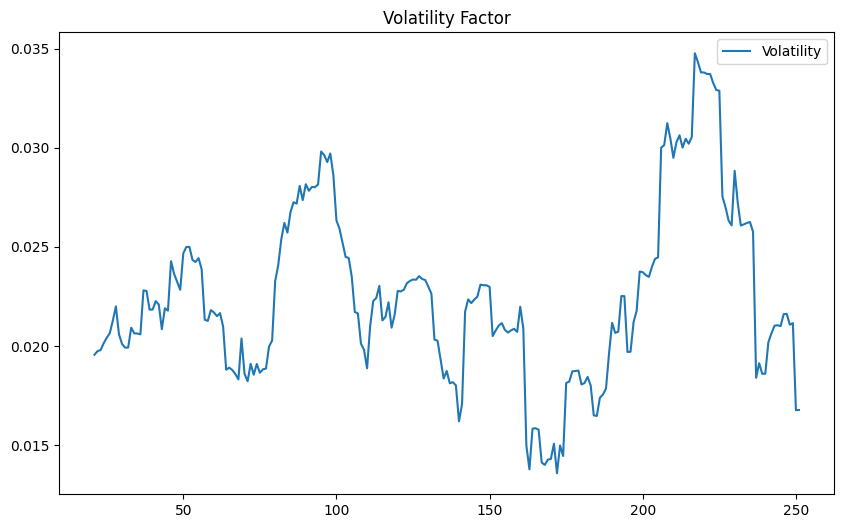

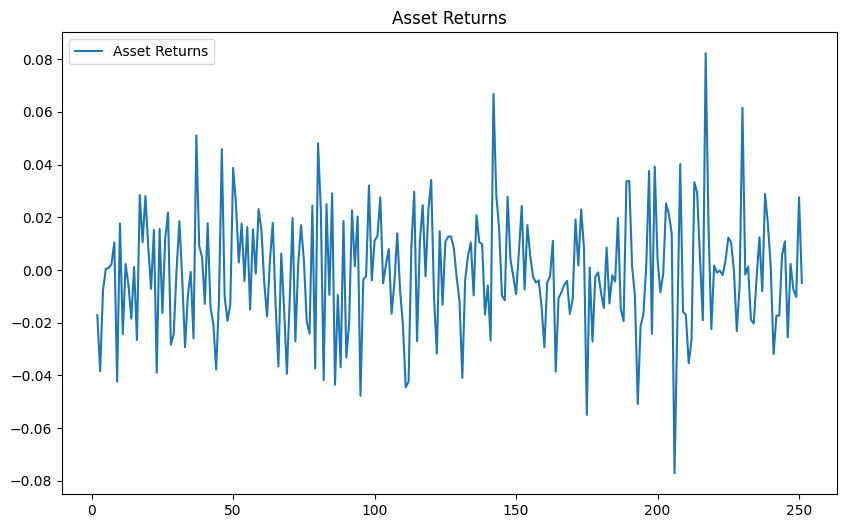

Sharpe Ratio: -0.9452074040104679
Alpha: nan, Beta: nan
R-Squared Value: nan
One or more of the input data sets are empty.
0        Date    Open    High     Low   Close    Volume      MA5  MA30  \
1  2022-01-03  335.35  338.00  329.78  334.75  28918013      NaN   NaN   
2  2022-01-04  334.83  335.20  326.12  329.01  32674306      NaN   NaN   
3  2022-01-05  325.86  326.07  315.98  316.38  40054327      NaN   NaN   
4  2022-01-06  313.15  318.70  311.49  313.88  39646148      NaN   NaN   
5  2022-01-07  314.15  316.50  310.09  314.04  32720018  321.612   NaN   

0  Price_Range  Momentum  Moving_Average  
1         8.22       NaN             NaN  
2         9.08       NaN             NaN  
3        10.09       NaN             NaN  
4         7.21       NaN             NaN  
5         6.41       NaN             NaN  


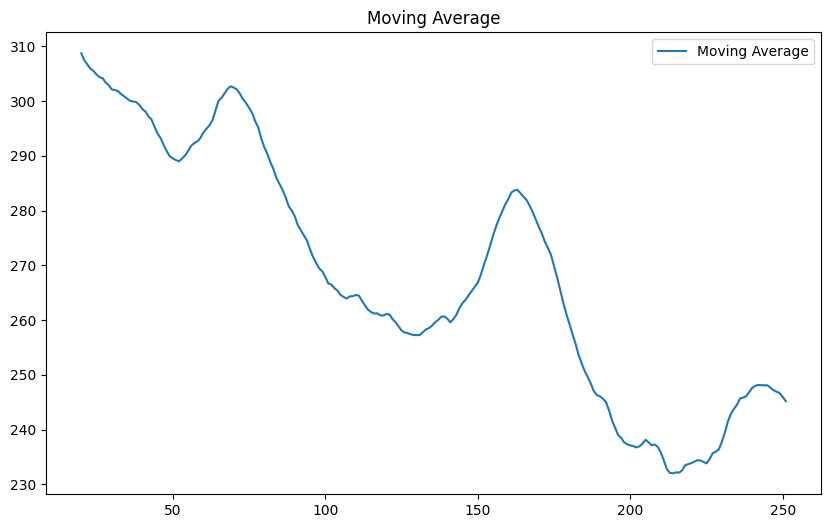

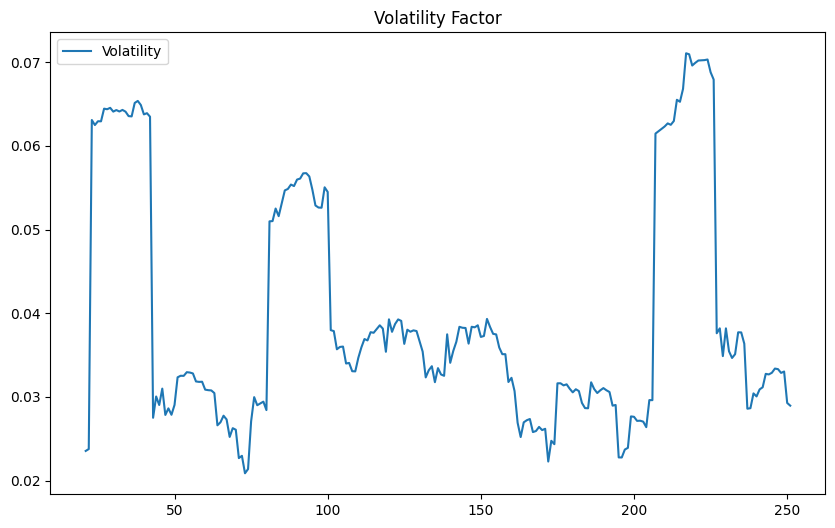

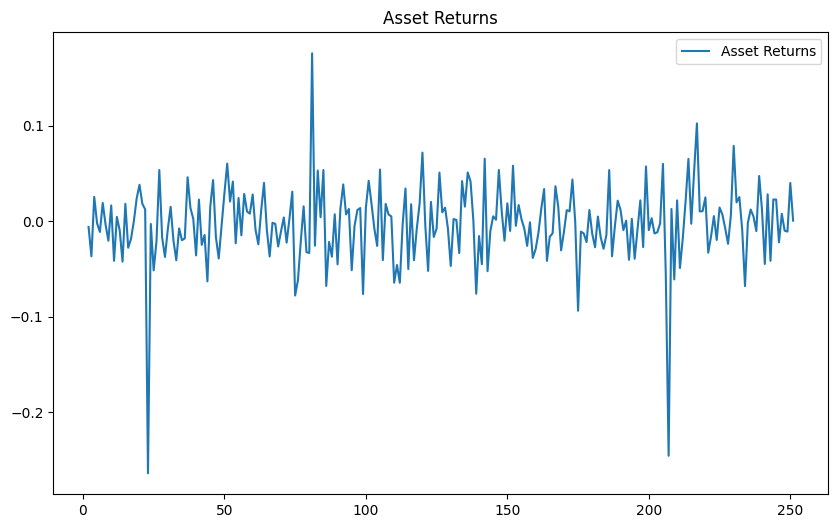

Sharpe Ratio: -0.5735995364551825
Alpha: nan, Beta: nan
R-Squared Value: nan
One or more of the input data sets are empty.
0        Date    Open    High     Low   Close    Volume      MA5  MA30  \
1  2022-01-03  338.30  341.08  337.19  338.54  14562849      NaN   NaN   
2  2022-01-04  339.95  343.09  331.87  336.53  15997974      NaN   NaN   
3  2022-01-05  333.02  335.76  323.84  324.17  20564521      NaN   NaN   
4  2022-01-06  322.82  339.17  322.72  332.46  27962809      NaN   NaN   
5  2022-01-07  332.74  337.00  328.88  331.79  14722020  332.698   NaN   

0  Price_Range  Momentum  Moving_Average  
1         3.89       NaN             NaN  
2        11.22       NaN             NaN  
3        11.92       NaN             NaN  
4        16.45       NaN             NaN  
5         8.12       NaN             NaN  


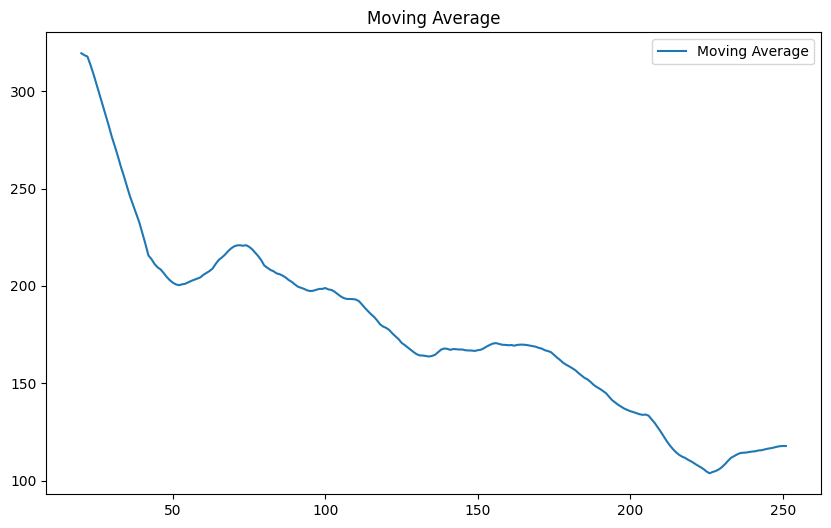

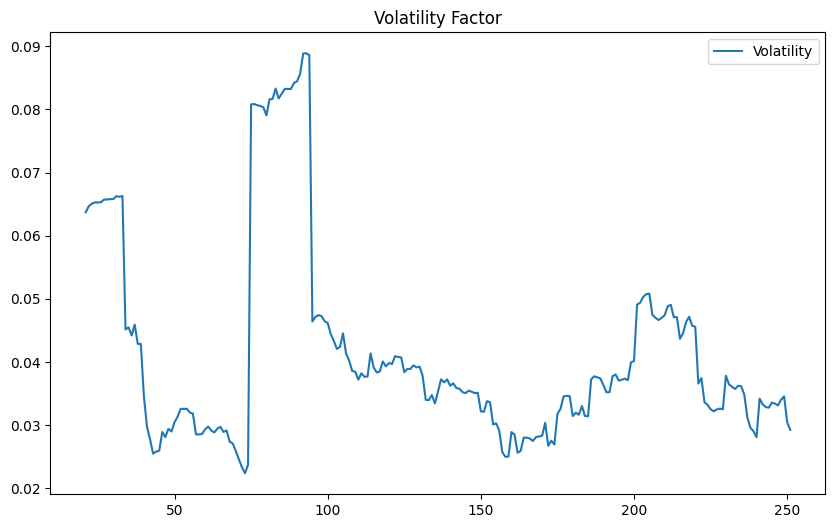

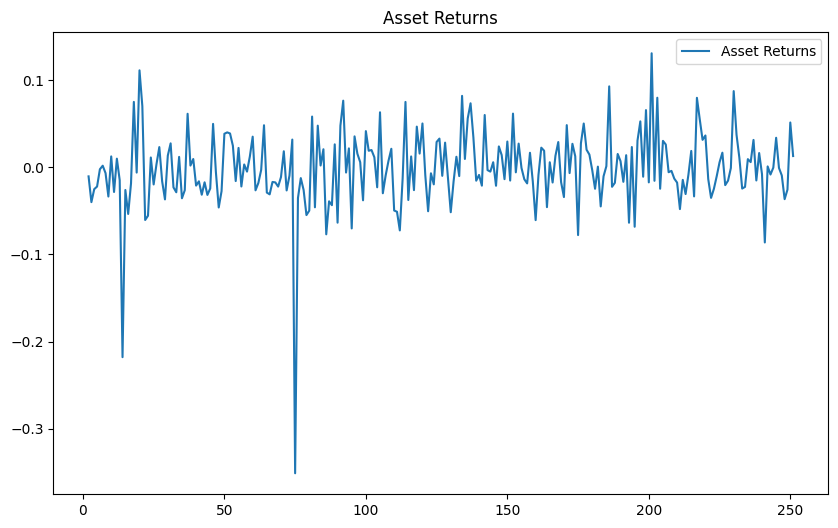

Sharpe Ratio: -0.4920564930469598
Alpha: nan, Beta: nan
R-Squared Value: nan
One or more of the input data sets are empty.
0        Date    Open    High     Low   Close   Volume      MA5  MA30  \
1  2022-01-03  605.61  609.99  590.56  597.37  3068808      NaN   NaN   
2  2022-01-04  599.91  600.41  581.60  591.15  4393135      NaN   NaN   
3  2022-01-05  592.00  592.84  566.88  567.52  4148749      NaN   NaN   
4  2022-01-06  554.34  563.36  542.01  553.29  5711795      NaN   NaN   
5  2022-01-07  549.46  553.43  538.22  541.06  3382873  570.078   NaN   

0  Price_Range  Momentum  Moving_Average  
1        19.43       NaN             NaN  
2        18.81       NaN             NaN  
3        25.96       NaN             NaN  
4        21.35       NaN             NaN  
5        15.21       NaN             NaN  


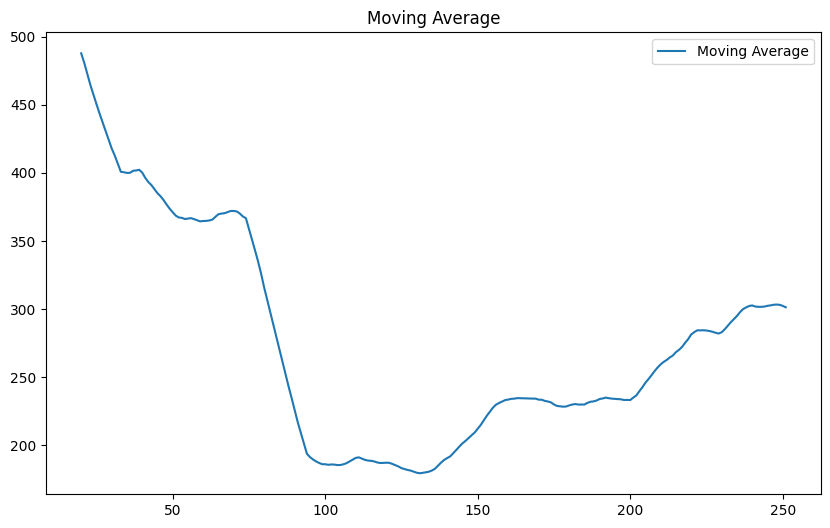

In [ ]:
for df in dataframes:
    asset_returns = calculate_asset_returns(df)
    calculate_and_visualize_volatility(df)
    calculate_and_visualize_sharpe_ratio(df)
    alpha, beta = calculate_alpha_and_beta(asset_returns, market_returns)
    print(f"Alpha: {alpha}, Beta: {beta}")
    calculate_and_visualize_r_squared(asset_returns, market_returns)
    calculate_and_visualize_technical_indicator(df, 'MA')


    if asset_returns.empty or market_returns.empty or risk_factors.empty:
      print("One or more of the input data sets are empty.")
    else:

      common_dates = asset_returns.index.intersection(market_returns.index).intersection(risk_factors.index)
      asset_returns_aligned = asset_returns.loc[common_dates]
      market_returns_aligned = market_returns.loc[common_dates]
      risk_factors_aligned = risk_factors.loc[common_dates]

      asset_returns_aligned = asset_returns_aligned.dropna()
      market_returns_aligned = market_returns_aligned.dropna()
      risk_factors_aligned = risk_factors_aligned.dropna()

      factor_model_analysis(asset_returns_aligned, market_returns_aligned, risk_factors_aligned)

    print(df.head())